# EnergyPlus Parameterization and Sensitivity Analysis for Residential Single Family Homes


## Daniel Xu, Keller Lab

This notebook was created in order to document the workflow and processes of EnergyPlus within Python. This is for my project involving the parameterization of EnergyPlus. Given that EnergyPlus has over 2000 available inputs, more research needs to be done in order to document which parameters are most significant and relevant in home energy modeling and simulations. 

The goal of this project is to run EnergyPlus on a model single family residential home. Some of the inputs will be fixed to default variables. Other variables, such as window thickness, thermostat set-points, etc. will be varied on pre-defined distributions. 

The distributions will be defined as seen in this paper: 
https://www.sciencedirect.com/science/article/abs/pii/S037877881631372X?via=ihub

### Importing necessary libraries

In [1]:
# For working with IDF files and EnergyPlus
from eppy import modeleditor
from eppy.modeleditor import IDF

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For file and directory operations
import os
import shutil

# For working with time and dates
from datetime import datetime, timedelta

# For HTTP requests
import requests

# For running external commands
import subprocess

# For reading ESO output files
import esoreader

# For working with weather data and EPW files
import diyepw

# For working with directories
import shutil

### Changing the working directory 

In [2]:
# os.chdir("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts")
# print("Current working directory:", os.getcwd())

### Setting EnergyPlus Input Data Dictionary

In [3]:
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"
IDF.setiddname(idd_file_path)

### Setting a Skeleton IDF File 

This modifiable IDF file is provided by EnergyPlus in its initial download. It provides a mock residential home in Chicago with multiple zones. I will assume that some of the inputs are fixed and others are varied on a distribution. 

Directly from the EnergyPlus documentation: 

"This file does the basic test of an air distribution system in a residential home. A two speed heat pump with a supplmental gas heater provides space heating and cooling. It provides ventilation through the ZoneAirBalance:OutdoorAir model."

In [4]:
idfname = "/Applications/EnergyPlus-24-2-0/ExampleFiles/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf"

preidf = IDF(idfname)

# preidf.printidf()
# print(preidf.idfobjects['Site:Location'])

## Creating a hot water system in the IDF file

In [5]:
# # Assuming preidf is an initialized IDF object and has the appropriate IDD set

# # Define the water heater
# water_heater = preidf.newidfobject("WATERHEATER:MIXED")
# water_heater.Name = "New Water Heater"
# water_heater.Tank_Volume = "0.15"  # cubic meters
# water_heater.Heater_Maximum_Capacity = "2000"  # watts
# water_heater.Heater_Minimum_Capacity = "1000"  # watts
# water_heater.Setpoint_Temperature_Schedule_Name = "Hot Water Setpoint Temp"
# water_heater.Use_Side_Inlet_Node_Name = "Hot Water Use Inlet Node"
# water_heater.Use_Side_Outlet_Node_Name = "Hot Water Use Outlet Node"
# water_heater.Source_Side_Inlet_Node_Name = "Hot Water Source Inlet Node"
# water_heater.Source_Side_Outlet_Node_Name = "Hot Water Source Outlet Node"
# water_heater.Ambient_Temperature_Indicator = "Zone"
# water_heater.Ambient_Temperature_Zone_Name = "Appropriate Zone Name"  # Specify the correct zone name here
# water_heater.Heater_Fuel_Type = "Electricity"
# water_heater.Heater_Thermal_Efficiency = 0.92  # Fractional efficiency

# # Connect nodes to loops here, ensuring they're part of a PlantLoop or similar
# # Example:
# # Define a new loop or ensure these nodes are included in an existing loop definition

# # Save the IDF file
# preidf.save("/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/skeleton.idf")

### Weather Station Data Retrieval for EnergyPlus Simulations

This project aims to enhance the accuracy of building energy simulations by sourcing precise local weather data. By leveraging the NCEI (National Centers for Environmental Information) API, we are able to identify and retrieve data from the nearest weather station to any specified location. This localized weather data is crucial for feeding into EnergyPlus simulations, ensuring that our building models operate under realistic environmental conditions. The accurate simulation of energy usage and needs based on actual weather data helps in designing more efficient and sustainable buildings.

For more detailed information on how to utilize the NCEI API, including obtaining access tokens and making API requests, please visit the NCEI Web Services Documentation.

In [6]:
# def get_active_weather_stations(api_key, lat, lon):
#     base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations'
#     headers = {'token': api_key}
#     # Define the date one year ago from today
#     one_year_ago = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

#     # Set the request to retrieve more stations for a broader check
#     params = {
#         'extent': f'{lat-0.05},{lon-0.05},{lat+0.05},{lon+0.05}',
#         'limit': '1000',  # Adjust limit as needed
#         'sortfield': 'mindate',
#         'sortorder': 'desc'
#     }

#     response = requests.get(base_url, headers=headers, params=params)
    
#     if response.status_code != 200:
#         print(f"Failed to fetch data: {response.status_code} - {response.text}")
#         return []

#     try:
#         data = response.json()
#         active_stations = []
#         # Filter stations by checking if the 'maxdate' is within the last year
#         for station in data.get('results', []):
#             if station['maxdate'] >= one_year_ago:
#                 active_stations.append(station)
#         return active_stations
#     except ValueError:
#         print("Failed to decode JSON from response.")
#         return []

# api_key = 'SrgpVmvZhbtZXRSdBgknhaRSQlhTNzBt'
# latitude = 41.78  
# longitude = -87.75  

# active_stations = get_active_weather_stations(api_key, latitude, longitude)
# print(f"Found {len(active_stations)} active stations:")
# for station in active_stations:
#     print(station)


Based on this location, we will then use the diyepw package to create time series weather data. More information about diyepw can be found at: 

https://diyepw.readthedocs.io/en/latest/tutorial.html (PNNL)

In [7]:
# Get the current working directory and store it
scripts_dir = os.getcwd()

# Create the output directory if it does not exist
os.makedirs("weather_data", exist_ok=True)

# Changing to this directory
os.chdir("weather_data")

diyepw.create_amy_epw_files_for_years_and_wmos(
  [2020,2021,2022,2023],
  [725300],
  max_records_to_interpolate=6,
  max_records_to_impute=48,
  max_missing_amy_rows=5,
  allow_downloads=True,
  amy_epw_dir='./'
)

# Change back to the scripts directory
os.chdir(scripts_dir)

2025-02-04 16:57:23,114 Creating AMY EPW for year 2020 and WMO 725300...
2025-02-04 16:57:23,114 No amy_dir was specified - downloaded AMY files will be stored in the default location at /Users/danielxu/miniconda3/envs/eplus/lib/python3.8/site-packages/diyepw/data/noaa_isd_lite_files
2025-02-04 16:57:23,144 TMY EPW file (/Users/danielxu/miniconda3/envs/eplus/lib/python3.8/site-packages/diyepw/data/tmy_epw_files/USA_IL_Chicago.OHare.Intl.AP.725300_TMY3.epw) already exists, won't download again.
2025-02-04 16:57:23,158 2020 is a leap year, using the interpolation strategy to populate TMY data for Feb. 29
2025-02-04 16:57:23,195 File already exists at ./USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2020.epw, so a new one won't be generated.
2025-02-04 16:57:23,196 Creating AMY EPW for year 2021 and WMO 725300...
2025-02-04 16:57:23,196 No amy_dir was specified - downloaded AMY files will be stored in the default location at /Users/danielxu/miniconda3/envs/eplus/lib/python3.8/site-packages/diyep

In [8]:
output_idf_dir = 'randomized_idfs'
    
# Create the output directory if it does not exist
os.makedirs(output_idf_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_idf_dir):
    file_path = os.path.join(output_idf_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

### Editing IDF parameters 



In [22]:
import numpy as np
from eppy.modeleditor import IDF

def update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True):
    # Set the EnergyPlus IDD file and load the skeleton IDF.
    IDF.setiddname(idd_file_path)
    if verbose:
        print(f"IDD set from: {idd_file_path}")

    # Means from the original IDF
    mean_heating_sp = 22.0  # °C
    mean_cooling_sp = 26.6  # °C
    mean_people_per_area = 3.0  # people/m²
    mean_infil_flow_rate = 0.01  # m³/s
    mean_watts_equip = 500  # W
    mean_watts_lights = 1000  # W

    sd = 0.05  # standard deviation multiplier

    # Calculating standard deviations
    sd_heating_sp = sd * mean_heating_sp
    sd_cooling_sp = sd * mean_cooling_sp
    sd_people_per_area = sd * mean_people_per_area
    sd_infil_flow_rate = sd * mean_infil_flow_rate
    sd_mean_watts_equip = sd * mean_watts_equip
    sd_mean_watts_lights = sd * mean_watts_lights

    if verbose:
        print("Starting parameter updates for 10 iterations.")

    for i in range(10):
        if verbose:
            print(f"\n--- Iteration {i+1}/10 ---")
        # Load the IDF file from the skeleton
        idf = IDF(skeleton_idf_path)
        if verbose:
            print(f"Loaded skeleton IDF file: {skeleton_idf_path}")

        # Draw new heating and cooling setpoints from normal distributions;
        # ensure that the cooling setpoint is at least 2°C above the heating setpoint.
        valid_setpoints = False
        while not valid_setpoints:
            new_heating_setpoint = np.random.normal(mean_heating_sp, sd_heating_sp)
            new_cooling_setpoint = np.random.normal(mean_cooling_sp, sd_cooling_sp)
            if new_heating_setpoint > 0 and new_cooling_setpoint > 0 and (new_cooling_setpoint - new_heating_setpoint > 2):
                valid_setpoints = True
        if verbose:
            print(f"New heating setpoint: {new_heating_setpoint:.2f}°C, cooling setpoint: {new_cooling_setpoint:.2f}°C")

        # Draw new people per area value
        new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        while new_people_per_area < 0.0:
            new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        if verbose:
            print(f"New people per area: {new_people_per_area:.6f} people/m²")

        # Assign different infiltration rates for different zones (living, garage, attic)
        new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_living < 0.0:
            new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_garage < 0.0:
            new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_attic < 0.0:
            new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        if verbose:
            print(f"New infiltration rates (m³/s): Living: {new_infil_flow_rate_living:.6e}, Garage: {new_infil_flow_rate_garage:.6e}, Attic: {new_infil_flow_rate_attic:.6e}")

        # Draw new equipment and lighting power values
        new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        while new_watts_equip < 0.0:
            new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        while new_watts_lights < 0.0:
            new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        if verbose:
            print(f"New equipment power: {new_watts_equip:.1f} W, new lighting power: {new_watts_lights:.1f} W")

        # Update building parameters in the IDF

        try:
            people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
            # Assume the field at index 5 corresponds to People per Area (check your IDD)
            people_object.fieldvalues[5] = new_people_per_area
            if verbose:
                print(f"Updated PEOPLE object 'LIVING ZONE People' with value: {new_people_per_area:.6f}")
        except Exception as e:
            if verbose:
                print("Error updating PEOPLE object:", e)

        try:
            infil_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
            # Assume field index 5 is the design flow rate (check your IDD)
            infil_living.fieldvalues[5] = new_infil_flow_rate_living
            if verbose:
                print(f"Updated infiltration for Living Zone to: {new_infil_flow_rate_living:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Living Zone:", e)

        try:
            infil_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
            infil_garage.fieldvalues[5] = new_infil_flow_rate_garage
            if verbose:
                print(f"Updated infiltration for Garage Zone to: {new_infil_flow_rate_garage:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Garage Zone:", e)

        try:
            infil_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
            infil_attic.fieldvalues[5] = new_infil_flow_rate_attic
            if verbose:
                print(f"Updated infiltration for Attic Zone to: {new_infil_flow_rate_attic:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Attic Zone:", e)

        try:
            lights_obj = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
            lights_obj.Lighting_Level = new_watts_lights
            if verbose:
                print(f"Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: {new_watts_lights:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating LIGHTS object:", e)

        try:
            equip_obj = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
            equip_obj.Design_Level = new_watts_equip
            if verbose:
                print(f"Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: {new_watts_equip:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating ELECTRICEQUIPMENT object:", e)

        try:
            heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
            # Assuming field 6 holds the setpoint value (check your IDD ordering)
            heating_schedule.fieldvalues[6] = str(round(new_heating_setpoint, 2))
            if verbose:
                print(f"Updated 'Dual Heating Setpoints' to: {round(new_heating_setpoint, 2)}°C")
        except Exception as e:
            if verbose:
                print("Error updating Dual Heating Setpoints:", e)

        try:
            cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
            cooling_schedule.fieldvalues[6] = str(round(new_cooling_setpoint, 2))
            if verbose:
                print(f"Updated 'Dual Cooling Setpoints' to: {round(new_cooling_setpoint, 2)}°C")
        except Exception as e:
            if verbose:
                print("Error updating Dual Cooling Setpoints:", e)

        # ----- NEW CODE: Remove design days and set run period for the entire year -----

        # Remove all SizingPeriod:DesignDay objects from the IDF.
        if "SizingPeriod:DesignDay" in idf.idfobjects:
            design_days = list(idf.idfobjects["SizingPeriod:DesignDay"])
            for dd in design_days:
                idf.removeidfobject(dd)
            if verbose:
                print("Removed all SizingPeriod:DesignDay objects.")

        # Remove any existing RunPeriod objects
        if "RunPeriod" in idf.idfobjects:
            run_periods = list(idf.idfobjects["RunPeriod"])
            for rp in run_periods:
                idf.removeidfobject(rp)
            if verbose:
                print("Removed all RunPeriod objects.")

        # Create a new RunPeriod object that covers the entire year.
        # (Note: The field names must match your IDD. Adjust the keys/values as needed.)
        new_run = idf.newidfobject(
            "RunPeriod",
            Name="YearSimulation",
            Begin_Month=1,
            Begin_Day_of_Month=1,
            Begin_Year="",
            End_Month=12,
            End_Day_of_Month=31,
            End_Year="",
            Day_of_Week_for_Start_Day="Monday",
            Use_Weather_File_Holidays_and_Special_Days="Yes",
            Use_Weather_File_Daylight_Saving_Period="Yes",
            Apply_Weekend_Holiday_Rule="No",
            Use_Weather_File_Rain_Indicators="Yes",
            Use_Weather_File_Snow_Indicators="Yes"
        )
        if verbose:
            print("Created new RunPeriod for the entire year.")

        # Update the SimulationControl object so that the simulation runs using the weather file.
        # (In the original file, simulation was set up to run sizing periods only.)
        try:
            sim_control = idf.idfobjects["SimulationControl"][0]
            # Field order (by the provided file):
            #   1: Do Zone Sizing Calculation
            #   2: Do System Sizing Calculation
            #   3: Do Plant Sizing Calculation
            #   4: Run Simulation for Sizing Periods
            #   5: Run Simulation for Weather File Run Periods
            #   6: Do HVAC Sizing Simulation for Sizing Periods
            #   7: Maximum Number of HVAC Sizing Simulation Passes
            sim_control.fieldvalues[3] = "No"   # Do NOT run simulation for sizing periods.
            sim_control.fieldvalues[4] = "Yes"  # DO run simulation for weather file run periods.
            if verbose:
                print("Updated SimulationControl to run simulation for weather file run periods.")
        except Exception as e:
            if verbose:
                print("Error updating SimulationControl:", e)

        # Save the updated IDF file.
        output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
        idf.save(output_file_path)
        if verbose:
            print(f"Saved updated IDF file to: {output_file_path}")
            
update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True)

IDD set from: /Applications/EnergyPlus-24-2-0/Energy+.idd
Starting parameter updates for 10 iterations.

--- Iteration 1/10 ---
Loaded skeleton IDF file: /Applications/EnergyPlus-24-2-0/ExampleFiles/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf
New heating setpoint: 23.34°C, cooling setpoint: 28.63°C
New people per area: 3.236460 people/m²
New infiltration rates (m³/s): Living: 9.645212e-03, Garage: 1.024898e-02, Attic: 1.029699e-02
New equipment power: 441.3 W, new lighting power: 979.6 W
Updated PEOPLE object 'LIVING ZONE People' with value: 3.236460
Updated infiltration for Living Zone to: 9.645212e-03
Updated infiltration for Garage Zone to: 1.024898e-02
Updated infiltration for Attic Zone to: 1.029699e-02
Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: 979.6 W
Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: 441.3 W
Updated 'Dual Heating Setpoints' to: 23.34°C
Updated 'Dual Cooling Setpoints' to: 28.63°C
Removed all SizingPeriod:DesignDay object

In [27]:
def update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True):
    # Load the EnergyPlus IDD file
    IDF.setiddname(idd_file_path)
    if verbose:
        print(f"IDD set from: {idd_file_path}")

    # Means from the original IDF
    mean_heating_sp = 22.0  # °C
    mean_cooling_sp = 26.6  # °C
    mean_people_per_area = 3.0  # people
    mean_infil_flow_rate = 0.01  # m3/s
    mean_watts_equip = 500  # W
    mean_watts_lights = 1000  # W

    sd = 0.05

    # Calculating standard deviations
    sd_heating_sp = sd * mean_heating_sp
    sd_cooling_sp = sd * mean_cooling_sp
    sd_people_per_area = sd * mean_people_per_area
    sd_infil_flow_rate = sd * mean_infil_flow_rate
    sd_mean_watts_equip = sd * mean_watts_equip
    sd_mean_watts_lights = sd * mean_watts_lights

    if verbose:
        print("Starting parameter updates for 10 iterations.")
    for i in range(10):
        if verbose:
            print(f"\n--- Iteration {i+1}/10 ---")
        # Load the IDF file
        idf = IDF(skeleton_idf_path)
        if verbose:
            print(f"Loaded skeleton IDF file: {skeleton_idf_path}")

        # Draw new heating and cooling setpoints from normal distributions
        valid_setpoints = False
        while not valid_setpoints:
            new_heating_setpoint = np.random.normal(mean_heating_sp, sd_heating_sp)
            new_cooling_setpoint = np.random.normal(mean_cooling_sp, sd_cooling_sp)
            if new_heating_setpoint > 0 and new_cooling_setpoint > 0 and (new_cooling_setpoint - new_heating_setpoint > 2):
                valid_setpoints = True
        if verbose:
            print(f"New heating setpoint: {new_heating_setpoint:.2f}°C, cooling setpoint: {new_cooling_setpoint:.2f}°C")

        # Draw new people per area value
        new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        while new_people_per_area < 0.0:
            new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        if verbose:
            print(f"New people per area: {new_people_per_area:.6f} people/m²")

        # Assign different infiltration rates for different zones
        new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_living < 0.0:
            new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_garage < 0.0:
            new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_attic < 0.0:
            new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        if verbose:
            print(f"New infiltration rates (m³/s): Living: {new_infil_flow_rate_living:.6e}, Garage: {new_infil_flow_rate_garage:.6e}, Attic: {new_infil_flow_rate_attic:.6e}")

        # Draw new equipment and lighting power values
        new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        while new_watts_equip < 0.0:
            new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        while new_watts_lights < 0.0:
            new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        if verbose:
            print(f"New equipment power: {new_watts_equip:.1f} W, new lighting power: {new_watts_lights:.1f} W")

        # Update building parameters
        try:
            people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
            people_object.fieldvalues[5] = new_people_per_area
            if verbose:
                print(f"Updated PEOPLE object 'LIVING ZONE People' with value: {new_people_per_area:.6f}")
        except Exception as e:
            if verbose:
                print("Error updating PEOPLE object:", e)

        try:
            infiltration_object_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
            infiltration_object_living.fieldvalues[5] = new_infil_flow_rate_living
            if verbose:
                print(f"Updated infiltration for Living Zone to: {new_infil_flow_rate_living:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Living Zone:", e)

        try:
            infiltration_object_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
            infiltration_object_garage.fieldvalues[5] = new_infil_flow_rate_garage
            if verbose:
                print(f"Updated infiltration for Garage Zone to: {new_infil_flow_rate_garage:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Garage Zone:", e)

        try:
            infiltration_object_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
            infiltration_object_attic.fieldvalues[5] = new_infil_flow_rate_attic
            if verbose:
                print(f"Updated infiltration for Attic Zone to: {new_infil_flow_rate_attic:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Attic Zone:", e)

        try:
            lighting_object = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
            lighting_object.Lighting_Level = new_watts_lights
            if verbose:
                print(f"Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: {new_watts_lights:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating LIGHTS object:", e)

        try:
            equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
            equipment_object.Design_Level = new_watts_equip
            if verbose:
                print(f"Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: {new_watts_equip:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating ELECTRICEQUIPMENT object:", e)

        try:
            heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
            heating_schedule.fieldvalues[6] = str(round(new_heating_setpoint, 2))
            if verbose:
                print(f"Updated 'Dual Heating Setpoints' to: {round(new_heating_setpoint, 2)}°C")
        except Exception as e:
            if verbose:
                print("Error updating Dual Heating Setpoints:", e)

        try:
            cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
            cooling_schedule.fieldvalues[6] = str(round(new_cooling_setpoint, 2))
            if verbose:
                print(f"Updated 'Dual Cooling Setpoints' to: {round(new_cooling_setpoint, 2)}°C")
        except Exception as e:
            if verbose:
                print("Error updating Dual Cooling Setpoints:", e)

        output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
        idf.save(output_file_path)
        if verbose:
            print(f"Saved updated IDF file to: {output_file_path}")

# Example usage:
skeleton_idf_path = idfname  # Assuming idfname is defined elsewhere as the skeleton IDF path.
update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True)

IDD set from: /Applications/EnergyPlus-24-2-0/Energy+.idd
Starting parameter updates for 10 iterations.

--- Iteration 1/10 ---
Loaded skeleton IDF file: /Applications/EnergyPlus-24-2-0/ExampleFiles/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf
New heating setpoint: 20.77°C, cooling setpoint: 27.36°C
New people per area: 3.052059 people/m²
New infiltration rates (m³/s): Living: 9.660924e-03, Garage: 9.488120e-03, Attic: 9.841068e-03
New equipment power: 467.1 W, new lighting power: 1021.8 W
Updated PEOPLE object 'LIVING ZONE People' with value: 3.052059
Updated infiltration for Living Zone to: 9.660924e-03
Updated infiltration for Garage Zone to: 9.488120e-03
Updated infiltration for Attic Zone to: 9.841068e-03
Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: 1021.8 W
Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: 467.1 W
Updated 'Dual Heating Setpoints' to: 20.77°C
Updated 'Dual Cooling Setpoints' to: 27.36°C
Saved updated IDF file to: randomized_i

In [10]:
# def update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True):
#     # Load the EnergyPlus IDD file
#     IDF.setiddname(idd_file_path)

#     # Means from the original IDF
#     mean_heating_sp = 22.0                    # °C
#     mean_cooling_sp = 26.6                    # °C
#     mean_people_per_area = 3.0                # people/m²
#     mean_infil_flow_rate = 0.01               # ACH
#     mean_watts_per_area_equip = 13.33         # W/m²

#     sd = 0.05 
    
#     # Calculating standard deviations
#     sd_heating_sp = sd * mean_heating_sp
#     sd_cooling_sp = sd * mean_cooling_sp
#     sd_people_per_area = sd * mean_people_per_area
#     sd_infil_flow_rate = sd * mean_infil_flow_rate
#     sd_mean_watts_per_area_equip = sd * mean_watts_per_area_equip

#     for i in range(10):
#         # Load the IDF file
#         idf = IDF(skeleton_idf_path)

#         # Draw new heating and cooling setpoints from normal distributions
#         valid_setpoints = False
#         while not valid_setpoints:
#             new_heating_setpoint = np.random.normal(mean_heating_sp, sd_heating_sp)
#             new_cooling_setpoint = np.random.normal(mean_cooling_sp, sd_cooling_sp)
#             if new_heating_setpoint > 0 and new_cooling_setpoint > 0 and (new_cooling_setpoint - new_heating_setpoint > 2):
#                 valid_setpoints = True

#         new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
#         while new_people_per_area < 0.0:
#             new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)

#         new_infil_flow_rate = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         while new_infil_flow_rate < 0.0:
#             new_infil_flow_rate = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)

#         new_watts_per_area_equip = np.random.normal(mean_watts_per_area_equip, sd_mean_watts_per_area_equip)
#         while new_watts_per_area_equip < 0.0:
#             new_watts_per_area_equip = np.random.normal(mean_watts_per_area_equip, sd_mean_watts_per_area_equip)

#         # Update building parameters
#         people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
#         people_object.Number_of_People_Calculation_Method = "People/Area"
#         people_object.People_per_Floor_Area = new_people_per_area
#         people_object.fieldvalues[5] = ""
#         if verbose:
#             print(f"Updated {people_object.Name} to {new_people_per_area:.6f} people/m²")

#         infiltration_object_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
#         infiltration_object_living.Design_Flow_Rate_Calculation_Method = 'AirChanges/Hour'
#         infiltration_object_living.fieldvalues[8] = new_infil_flow_rate
#         infiltration_object_living.fieldvalues[5] = ""
#         if verbose:
#             print(f"Updated {infiltration_object_living.Name} to {new_infil_flow_rate:.6e} m³/s-m²")

#         infiltration_object_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
#         infiltration_object_garage.Design_Flow_Rate_Calculation_Method = 'AirChanges/Hour'
#         infiltration_object_garage.fieldvalues[8] = new_infil_flow_rate
#         infiltration_object_garage.fieldvalues[5] = ""
#         if verbose:
#             print(f"Updated {infiltration_object_garage.Name} to {new_infil_flow_rate:.6e} m³/s-m²")

#         infiltration_object_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
#         infiltration_object_attic.Design_Flow_Rate_Calculation_Method = 'AirChanges/Hour'
#         infiltration_object_attic.fieldvalues[8] = new_infil_flow_rate
#         infiltration_object_attic.fieldvalues[5] = ""
#         if verbose:
#             print(f"Updated {infiltration_object_attic.Name} to {new_infil_flow_rate:.6e} m³/s-m²")

#         lighting_object = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
#         lighting_object.Design_Level_Calculation_Method = 'Watts/Area'
#         lighting_object.fieldvalues[6] = new_watts_per_area_equip
#         lighting_object.Lighting_Level = ""
#         if verbose:
#             print(f"Updated {lighting_object.Name} to {new_watts_per_area_equip:.1f} W/m²")

#         equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
#         equipment_object.Design_Level_Calculation_Method = 'Watts/Area'
#         equipment_object.fieldvalues[6] = new_watts_per_area_equip
#         equipment_object.Design_Level = ""
#         if verbose:
#             print(f"Updated {equipment_object.Name} to {new_watts_per_area_equip:.1f} W/m²")

#         heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
#         heating_schedule.fieldvalues[6] = str(round(new_heating_setpoint, 2))
#         if verbose:
#             print(f"Updated Heating Setpoint to {new_heating_setpoint:.2f}°C")

#         cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
#         cooling_schedule.fieldvalues[6] = str(round(new_cooling_setpoint, 2))
#         if verbose:
#             print(f"Updated Cooling Setpoint to {new_cooling_setpoint:.2f}°C")

#         output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
#         idf.save(output_file_path)
#         if verbose:
#             print(f"File saved: {output_file_path}")

# skeleton_idf_path = idfname
# # Example call with verbose output disabled
# update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=False)

### Running the simulation and outputting the results

In [23]:
output_sim_dir = 'output'
    
# Create the output directory if it does not exist
os.makedirs(output_sim_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_sim_dir):
    file_path = os.path.join(output_sim_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

In [24]:
# Paths to your directories and files
idf_dir = "randomized_idfs"
weather_file = "weather_data/USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw"
idd_file_path = "/Applications/EnergyPlus-24-2-0/Energy+.idd"

In [25]:
def run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir):
    # Set the IDD file path
    IDF.setiddname(idd_file_path)
    
    # Get the list of IDF files
    idf_files = [f for f in os.listdir(output_idf_dir) if f.endswith('.idf')]
    
    for idf_file in idf_files:
        # Define paths
        idf_path = os.path.join(output_idf_dir, idf_file)
        idf_output_dir = os.path.join(output_sim_dir, os.path.splitext(idf_file)[0])
        
        # Create output directory if it doesn't exist
        os.makedirs(idf_output_dir, exist_ok=True)
        
        # Load the IDF file
        idf = IDF(idf_path)
        
        # Save a copy of the IDF file in the output directory
        idf_copy_path = os.path.join(idf_output_dir, os.path.basename(idf_path))
        idf.save(idf_copy_path)
        
        # Run the EnergyPlus simulation
        subprocess.run([
            'energyplus', 
            '--weather', weather_file, 
            '--output-directory', idf_output_dir, 
            '--idd', idd_file_path, 
            '--annual',
            '--readvars',
            idf_copy_path
        ])

run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir)

EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Warming up {8}
Warming up {9}
Warming up {10}
Warming up {11}
Warming up {12}
Warming up {13}
Warming up {14}
Warming up {15}
Warming up {16}
Warming up {17}
Warming up {18}
Warming up {19}
Warming up {20}
Warming up {21}
Warming up {22}
Warming up {23}
Warming up {24}
Warming up {25}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulat

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.2.0-94a887817b, YMD=2025.02.04 17:10
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=01/21/2007
Continuing Simulation at 01/21/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=02/10/2007
Continuing Simulation at 02/10/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/02/2007
Continuing Simulation at 03/02/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=03/22/2007
Continuing Simulation at 03/22/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=04/11/2007
Continuing Simulation at 04/11/2007 for YEARSIMULATION
Updating Shadowing Calculations, Start Date=

EnergyPlus Completed Successfully.


### Interpreting Results

In [14]:
all_data_frames = []

for i in range(1,11):
    folder_name = f"randomized_{i}"
    file_path = os.path.join(output_sim_dir, folder_name, "eplusmtr.csv")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path)
        # Tag this data with a Simulation ID
        temp_df["Simulation_ID"] = i
        
        all_data_frames.append(temp_df)
    else:
        print(f"File not found: {file_path}")

# Combine everything into one DataFrame
combined_df = pd.concat(all_data_frames, ignore_index=True)

# Print the first few rows to verify
print(combined_df.head())

# Print some info about the final DataFrame
print("Combined DataFrame shape:", combined_df.shape)

  Date/Time  Electricity:Facility [J](Monthly)  \
0   January                       9.658528e+09   
1  February                       8.129605e+09   
2     March                       8.122304e+09   
3     April                       5.004094e+09   
4       May                       3.397139e+09   

   Electricity:Building [J](Monthly)  InteriorLights:Electricity [J](Monthly)  \
0                       1.906418e+09                             9.707498e+08   
1                       1.682176e+09                             8.486406e+08   
2                       1.774814e+09                             8.979886e+08   
3                       1.710267e+09                             9.300467e+08   
4                       1.692631e+09                             9.707498e+08   

   Electricity:HVAC [J](Monthly)  NaturalGas:Facility [J](Monthly)  \
0                   7.752111e+09                      1.832660e+10   
1                   6.447428e+09                      1.471441e+10   
2 

In [15]:
# Path to the directory where you want to save the CSV
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'

# Create the directory if it does not exist
os.makedirs(analysis_dir, exist_ok=True)

# Create a file path for the output CSV
output_csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

combined_df["Electricity:Facility [J](Monthly)"] = pd.to_numeric(
    combined_df["Electricity:Facility [J](Monthly)"], 
    errors="coerce"
)

# Write the combined DataFrame to CSV
combined_df.to_csv(output_csv_path, index=False)

print(f"Data has been written to: {output_csv_path}")

Data has been written to: /Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis/combined_sims.csv


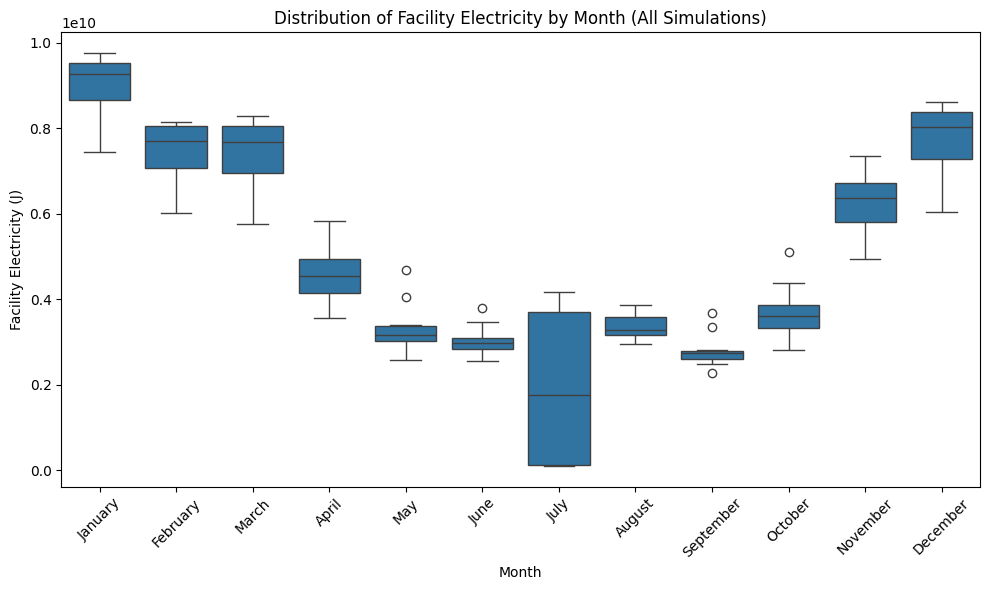

In [16]:
# Example path to your combined CSV file
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'
csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

# Load the data
df = pd.read_csv(csv_path)

# -----------------------------------------------------------------------------
# 1) Box Plot - Distribution of Facility Electricity by Month Across Simulations
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Date/Time', y='Electricity:Facility [J](Monthly)', data=df)
plt.title('Distribution of Facility Electricity by Month (All Simulations)')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)  # Rotate month labels if needed
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

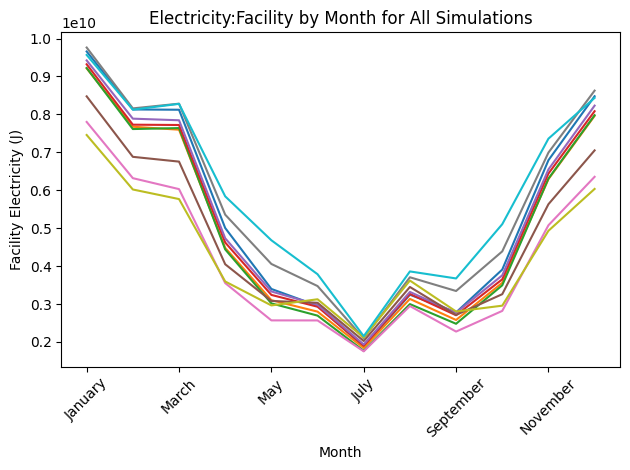

In [17]:
# -----------------------------------------------------------------------------
# 2) Line Plot - Each Simulation's Monthly Electricity Use
# -----------------------------------------------------------------------------
# This approach transforms the DataFrame into wide format, where each Simulation
# has a row, and each Month is a column. Then it plots all simulations as lines.

# Pivot so we have one row per Simulation_ID and one column per Month
# Define your month order
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

# Convert the Date/Time column to a Categorical with the specified order
df["Date/Time"] = pd.Categorical(
    df["Date/Time"], 
    categories=month_order, 
    ordered=True
)

# Now pivot again. The columns will appear in the custom order
pivoted = df.pivot_table(
    index='Simulation_ID',
    columns='Date/Time',
    values='Electricity:Facility [J](Monthly)'
)

# Plot
plt.figure(figsize=(10, 6))
pivoted.T.plot(legend=False)  # Transpose so Months go to the x-axis
plt.title('Electricity:Facility by Month for All Simulations')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

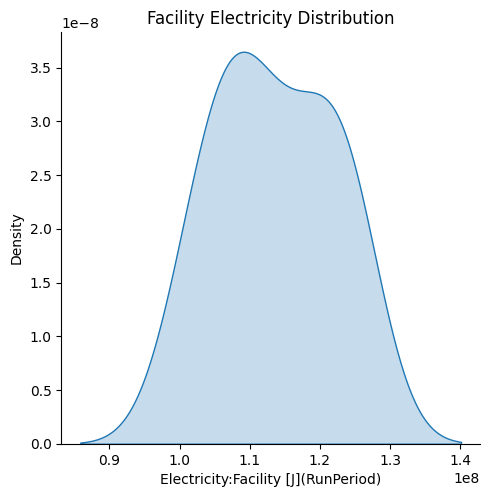

In [18]:
jan_df = df[df["Date/Time"] == "July"]
if not jan_df.empty:
    sns.displot(
        data=jan_df,
        x="Electricity:Facility [J](RunPeriod)",
        kind="kde",
        fill=True
    )
    plt.title("Facility Electricity Distribution")
    plt.show()
else:
    print("No data found for January.")

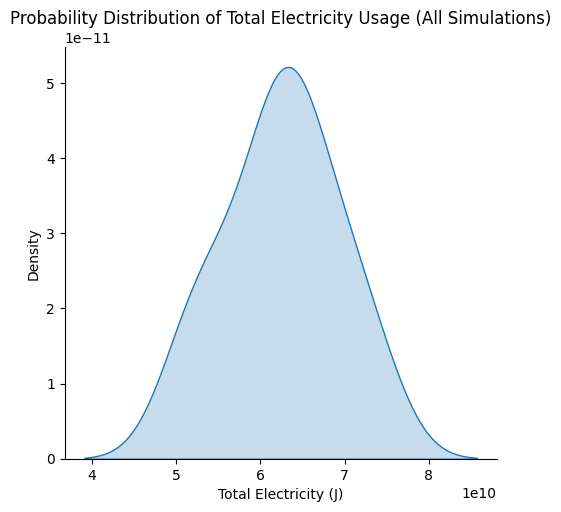

In [19]:
# Assume df has columns "Simulation_ID" and "Electricity:Facility [J](Monthly)"

# Sum the electricity usage for each simulation
df_summed = (
    df
    .groupby("Simulation_ID")["Electricity:Facility [J](Monthly)"]
    .sum()
    .reset_index(name="Total_Electricity")
)

# Plot the probability density of total electricity usage
sns.displot(data=df_summed, x="Total_Electricity", kind="kde", fill=True)
plt.title("Probability Distribution of Total Electricity Usage (All Simulations)")
plt.xlabel("Total Electricity (J)")
plt.ylabel("Density")
plt.show()

In [20]:
PATH_TO_ESO = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output/randomized_92/eplusout.eso'
eso = esoreader.read_from_path(PATH_TO_ESO)

variables = eso.dd.find_variable('Energy')

print(variables) 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output/randomized_92/eplusout.eso'

In [ ]:
index = eso.dd.index[('TimeStep,REPORTSCH', 'ACDXCOIL 1', 'Cooling Coil Total Cooling Energy')]

data = eso.data[index]

print(data)
# print(variables)

In [ ]:
# Define the start date and the time step duration (10 minutes for 6 steps per hour)
start_date = datetime(2024, 1, 1, 0, 0)
time_step_duration = timedelta(minutes=10)

# Define the schedule
schedule = [
    (datetime(2024, 1, 1), datetime(2024, 1, 20), 0.0),
    (datetime(2024, 1, 21), datetime(2024, 1, 21), 1.0),
    (datetime(2024, 1, 22), datetime(2024, 7, 20), 0.0),
    (datetime(2024, 7, 21), datetime(2024, 7, 21), 1.0),
    (datetime(2024, 7, 22), datetime(2024, 12, 31), 0.0),
]

# Generate a list of timestamps and corresponding schedule values
timestamps = []
schedule_values = []
current_time = start_date

for energy_value in data:
    # Find the applicable schedule value for the current time
    schedule_value = next(value for start, end, value in schedule if start <= current_time <= end)
    timestamps.append(current_time)
    schedule_values.append(schedule_value)
    current_time += time_step_duration

# Create the DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Schedule_Value': schedule_values,
    'Energy_Use': data
})

# Show the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file (optional)
df.to_csv('aligned_energy_use_data.csv', index=False)